-------------
### ライブラリのインポート

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.model_selection import train_test_split

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

ModuleNotFoundError: No module named 'numpy'

--------
### 実験設定

In [2]:
TARGET = "GMV"  # "GMV"か"BCR"
DATA = "part"  # "all" or "part"
DATA_SIZE = 200000  # データサイズ(訓練データとテストデータあわせて）
TEST_SIZE = 0.5  # テストデータの比率
THRESHOLD_LIST = [0.5, 2]  # 外れ値除外の閾値

RANDOM_STATE = 0  # 乱数シード

-----------
### データの前処理

In [3]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)

features_list = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]

if DATA == "all":
    df = df1
if DATA == "part":
    df = df2

In [4]:
df = df.copy()
df["BCR"] = np.where(df["GMV"] > 0, 1, 0)

In [37]:
df_new = pd.read_csv(R"C:\Users\HaruMomozu\Documents\pge_claims_records_2019.csv")
column_names = df_new.columns.tolist()
print(column_names)
# print(df_new.head())

numerical_cols = df_new.select_dtypes(include="number")
numerical_cols_names = numerical_cols.columns.tolist()
print(numerical_cols_names)

obj_new = "First Year Gross kWh"
features_list_new = [
    "Unit Direct Install Labor",
    "Unit Direct Install Materials",
    "Unit End User Rebate",
    "Unit Incentive to Others",
    "EUL Years",
    "RUL Years",
    "First Year Net kWh",
    "First Year Net kW",
    "First Year Net Therm",
    "Lifecycle Gross kWh",
    "Lifecycle Net Therm",
    "Gross Measure Cost",
    "End User Rebate",
    "Budget",
    "Electric Supply Cost",
    "Gas Supply Cost",
]

print(df_new["Number of Units"])


C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_14896\3355223420.py:1: DtypeWarning: Columns (5,6,13,42,43,44,49,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(R"C:\Users\HaruMomozu\Documents\pge_claims_records_2019.csv")


['Claim ID', 'Year', 'PA', 'Program ID', 'Program Name', 'Program Group', 'Program Segment', 'Program Status', 'Primary Sector', 'Program Sector', 'Statewide Program', 'Program Category', 'Direct Install', 'Financing', 'Program Implementer', 'Resource Flag', 'Non Resource Flag', 'Deemed Flag', 'Custom Flag', 'Upstream Flag', 'Midstream Flag', 'Downstream Flag', 'Audit Flag', 'Exclude From Budget Flag', 'Exclude from CE Flag', 'Claim Year Quarter', 'Measure Table', 'Measure Sector', 'Delivery Type', 'Building Type', 'Climate Zone', 'Gas Savings Profile', 'Gas Sector', 'Measure Electric End Use Shape', 'Target Sector', 'Measure Application Type', 'Measure Code', 'Measure Description', 'Measure Impact Type', 'Measure ID', 'Measure Qualifier', 'Interactive Effect Table Name', 'Location Cost Adjustment', 'Labor Rate', 'Measure Technology ID', 'Technology Group', 'Technology Type', 'Use Category', 'Use Subcategory', 'Pre-Existing Technology Description', 'Standard Technology Description', 'S

-------------
### 外れ値を除外しない場合

0のデータ数： 112476


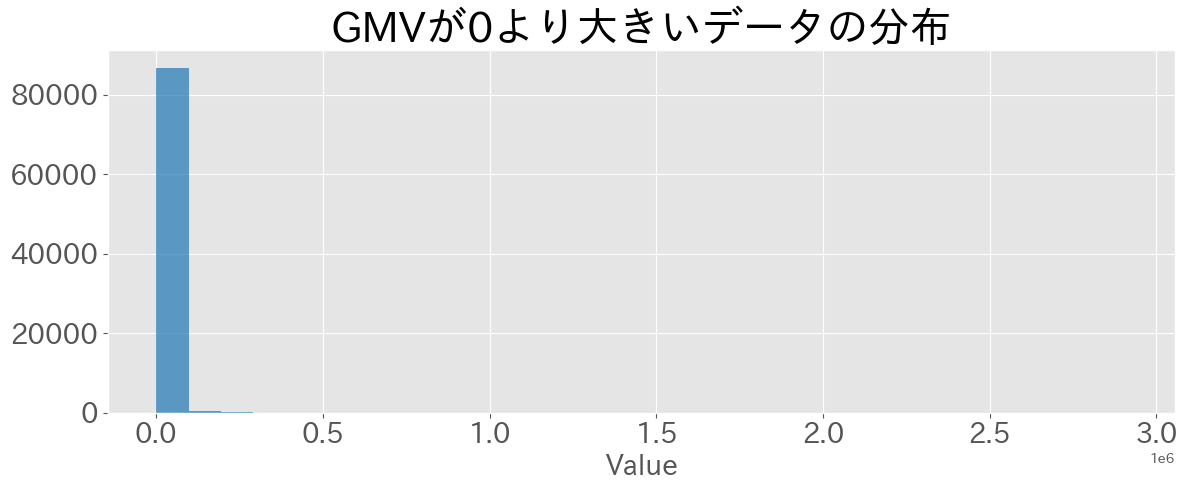

In [22]:
y = df[TARGET]
print("0のデータ数：", len(y[y == 0]))

# 0のデータと0以外のデータを区別して可視化
fig, axes = plt.subplots(1, 1, figsize=(12, 5))

# 0以外のデータのヒストグラム
axes.hist(
    y[y > 0],
    bins=30,
    color="#1f77b4",
    alpha=0.7,
)
axes.set_title("GMVが0より大きいデータの分布", fontsize=30)
axes.set_xlabel("Value", fontsize=20)
axes.tick_params(axis="both", labelsize=20)

plt.tight_layout()
plt.show()


-------------
### 外れ値除外

In [5]:
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

閾値：0.3
外れ値除外前のデータ数（訓練+テスト）: 200000
外れ値除外後のデータ数（訓練+テスト）: 185990
除外されたデータ数： 14010
0のデータ数： 112476


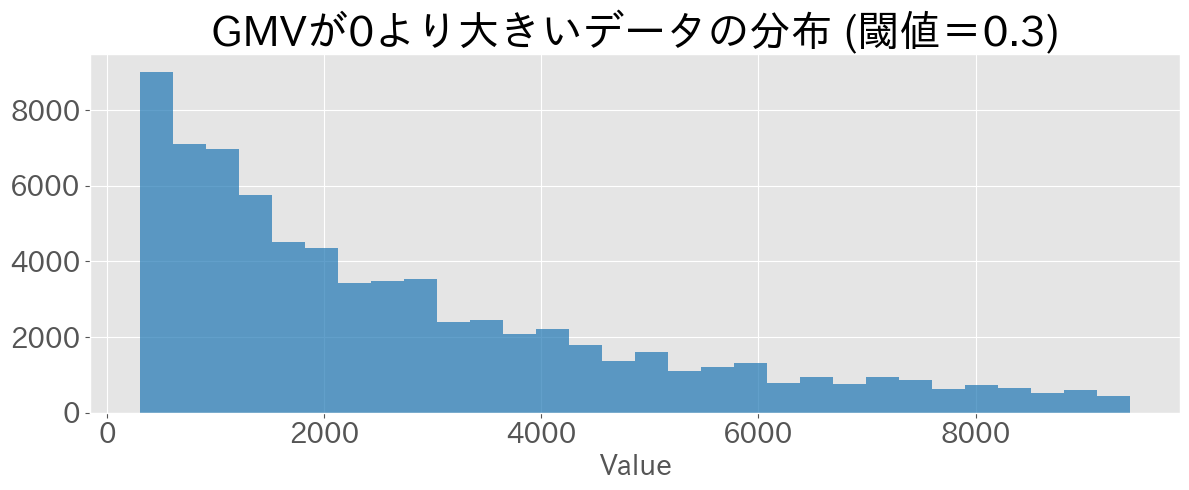

閾値：0.5
外れ値除外前のデータ数（訓練+テスト）: 200000
外れ値除外後のデータ数（訓練+テスト）: 190943
除外されたデータ数： 9057
0のデータ数： 112476


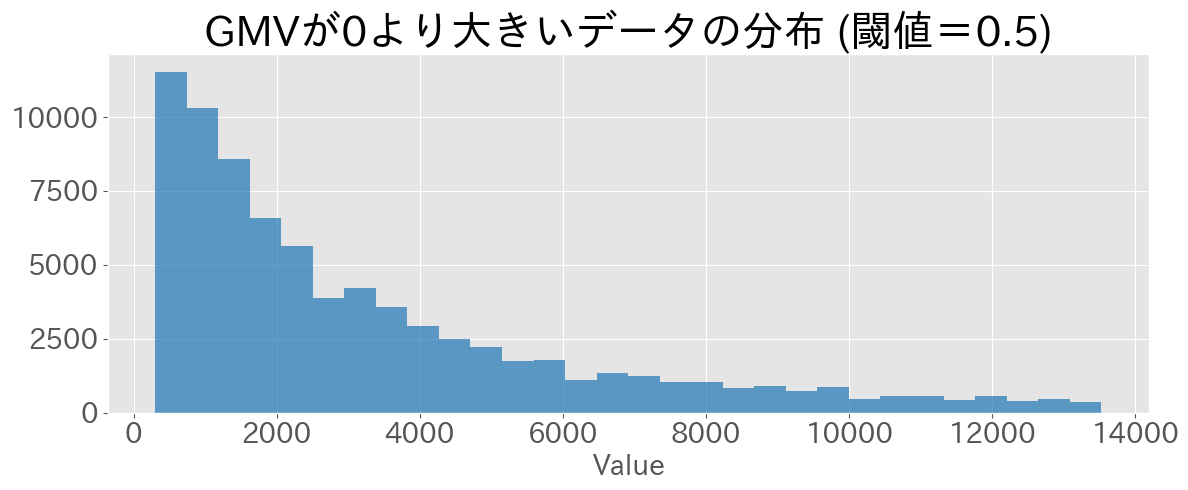

閾値：2
外れ値除外前のデータ数（訓練+テスト）: 200000
外れ値除外後のデータ数（訓練+テスト）: 198151
除外されたデータ数： 1849
0のデータ数： 112476


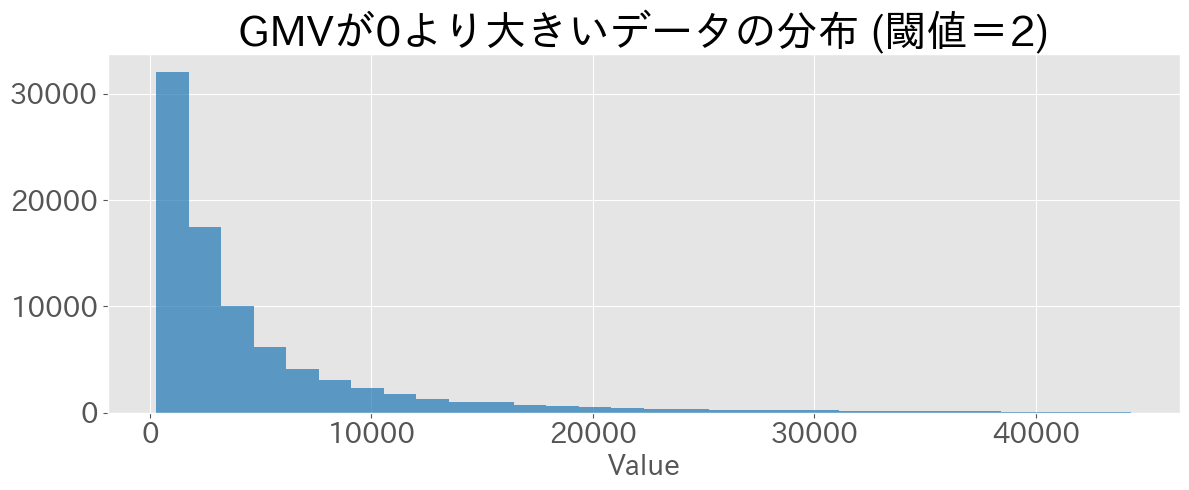

In [23]:
for i in range(len(THRESHOLD_LIST)):
    df_outliers_removed = remove_outliers_zscore(
        data=df, metric=TARGET, threshold=THRESHOLD_LIST[i]
    )
    df_outliers_removed = df_outliers_removed.reset_index(drop=True)  # 行を詰める
    y = df_outliers_removed[TARGET]
    print(f"閾値：{THRESHOLD_LIST[i]}")
    print("外れ値除外前のデータ数（訓練+テスト）:", DATA_SIZE)
    print("外れ値除外後のデータ数（訓練+テスト）:", len(df_outliers_removed))
    print("除外されたデータ数：", DATA_SIZE - len(df_outliers_removed))
    print("0のデータ数：", len(y[y == 0]))

    # 0のデータと0以外のデータを区別して可視化
    fig, axes = plt.subplots(1, 1, figsize=(12, 5))

    # 0以外のデータのヒストグラム
    axes.hist(
        y[y > 0],
        bins=30,
        color="#1f77b4",
        alpha=0.7,
    )
    axes.set_title(
        f"GMVが0より大きいデータの分布 (閾値＝{THRESHOLD_LIST[i]})", fontsize=30
    )
    axes.set_xlabel("Value", fontsize=20)
    axes.tick_params(axis="both", labelsize=20)

    plt.tight_layout()
    plt.show()
